![alt text](customs.png "Title")

# CUSTOMS DATASET OUTLIER ANALYSIS

## EXECUTIVE SUMMARY

This report is concerned with investigating customs data for the month of Febraury 2024. Due to the recent irregularities found on shipments tagged as shoes, eg. misdeclaration, fake goods,
data entry errors, this report will focus on footwear shipments. The primary goal is to detect anomalies in declared quantities and weights of the shipment through outlier analysis.  
- Filtered the dataset to include only footwear (7,028 shipments)
- Performed Elliptic Envelope, Isolation Forest, OCSVM, GMM
- Chose Elliptic Envelope as the most appropriate method.
- Predicted 71 Outliers
- Outliers were shipments with suspicious weights or quantities.
- Outliers are recommended to be inspected for misdeclaration of quantity, content, or worse contraband.

## PRELIMINARIES

### IMPORT PACKAGES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from matplotlib.colors import LogNorm
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')


### LOAD THE DATASET

In [2]:
df = pd.read_csv('DailyfiledFeb2024.csv')
codes = (
    df[df.HSCODE.astype(str).str.startswith('64')]
    .value_counts('HSCODE')
    .index
)
df_shoes = df[df.HSCODE.isin(codes)].copy()
df_shoes.describe()
df_shoes.dropna(subset=['QUANTITY', 'NETMASSKGS', 'UOM'], inplace=True)
X = df_shoes[['QUANTITY', 'GROSSMASSKGS']].values

## EXPLORATORY DATA ANALYSIS

In [3]:
df_shoes.describe()

,HSCODE,GROSSMASSKGS,NETMASSKGS,CUSTOMSVALUE,DUTIABLE_FOREIGN,EXCHANGE_RATE,DUTIABLEVALUEPHP,FREIGHT,INSURANCE,ARRASTRE,DUTY,VATTAXBASE,VAT,EXCISEADVALOREM,DUTIESTAXES,QUANTITY
count,7.028000e+03,7028.000000,7028.000000,7.028000e+03,7.028000e+03,7028.000000,7.028000e+03,7028.000000,7028.000000,7028.000000,7028.000000,7.028000e+03,7028.000000,7028.0,7.028000e+03,7028.000000
mean,6.404023e+10,1316.377779,1247.038049,6.628697e+04,6.861016e+04,46.127859,2.811663e+05,859.794387,1448.438829,1176.335157,10595.315001,2.945158e+05,35341.899444,0.0,4.605141e+04,1490.791346
std,9.487148e+06,3326.902574,3192.163124,2.545914e+05,2.626900e+05,21.375080,4.820711e+05,3200.185261,5778.126754,2664.462977,33475.589040,5.008020e+05,60096.240931,0.0,8.234391e+04,5461.273058
min,6.401100e+10,0.070000,0.070000,1.000000e-02,1.000000e-02,1.000000,5.600000e-01,0.000000,0.000000,0.000000,0.000000,1.832700e+02,21.990000,0.0,2.208000e+01,1.000000
25%,6.403400e+10,5.017500,4.292500,4.002750e+02,4.309225e+02,55.887000,2.104606e+04,9.000000,6.660000,0.000000,0.000000,2.438923e+04,2926.710000,0.0,5.503565e+03,6.000000
50%,6.403999e+10,92.200000,80.075000,2.655000e+03,2.786520e+03,56.000000,9.917320e+04,56.775000,42.370000,118.205000,1703.015000,1.088192e+05,13058.300000,0.0,1.740221e+04,108.000000
75%,6.404199e+10,625.345000,558.500000,1.261850e+04,1.371613e+04,56.185000,3.553728e+05,500.000000,262.020000,957.667500,7197.912500,3.741552e+05,44898.622500,0.0,5.710589e+04,593.250000
max,6.405900e+10,47020.000000,42318.000000,4.114142e+06,4.215111e+06,61.090000,7.227674e+06,76885.380000,98960.040000,42755.000000,866461.780000,7.234629e+06,868155.500000,0.0,1.666630e+06,261056.000000


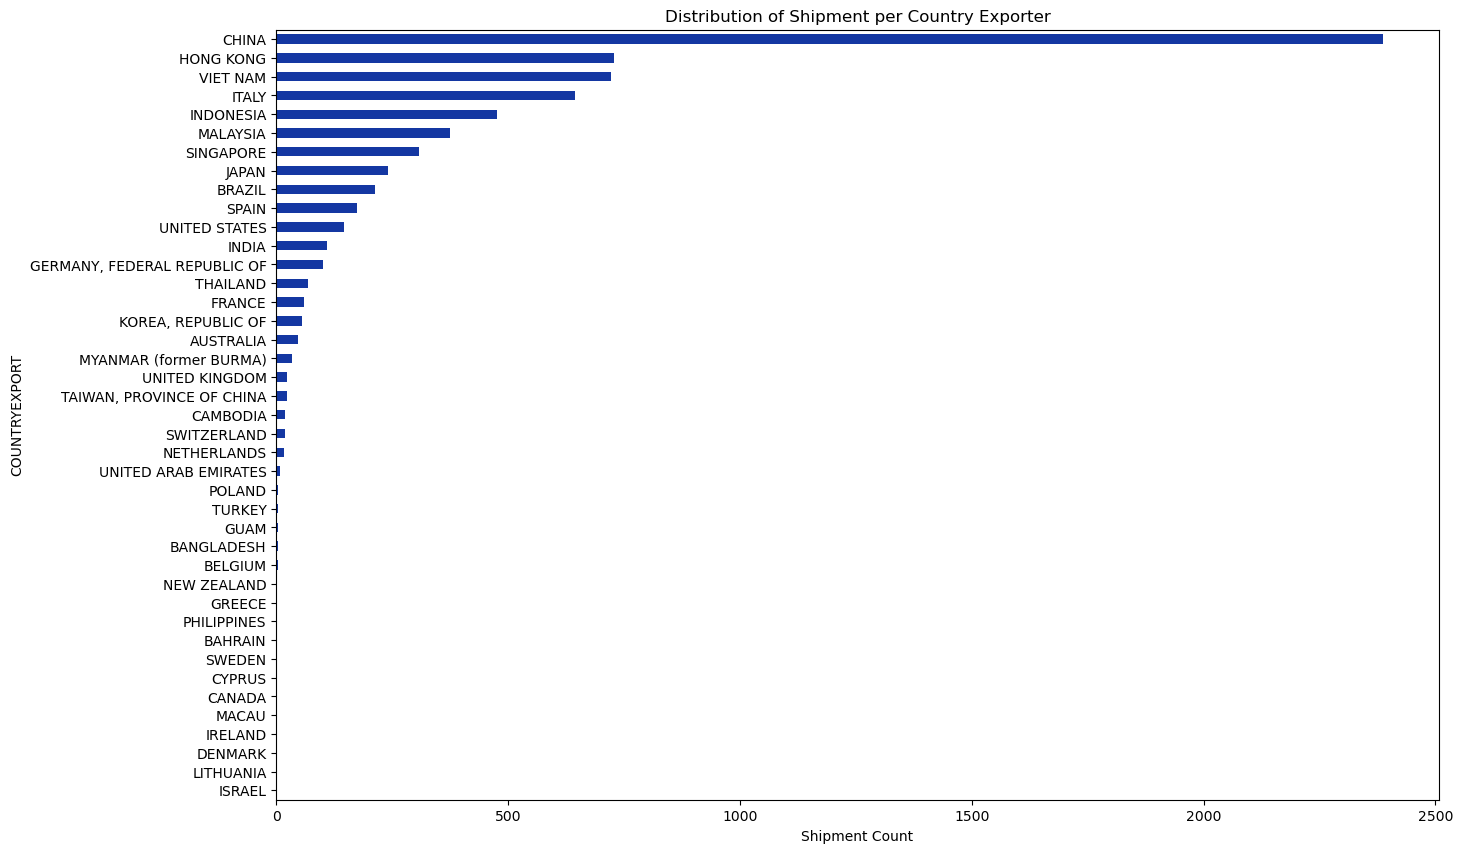

In [4]:
plt.figure(figsize=(15, 10))
(df_shoes
 .value_counts('COUNTRYEXPORT')
 .sort_values(ascending=True)
 .plot
 .barh(color='#1437A2')
 )
plt.title('Distribution of Shipment per Country Exporter')
plt.xlabel('Shipment Count')
plt.show()

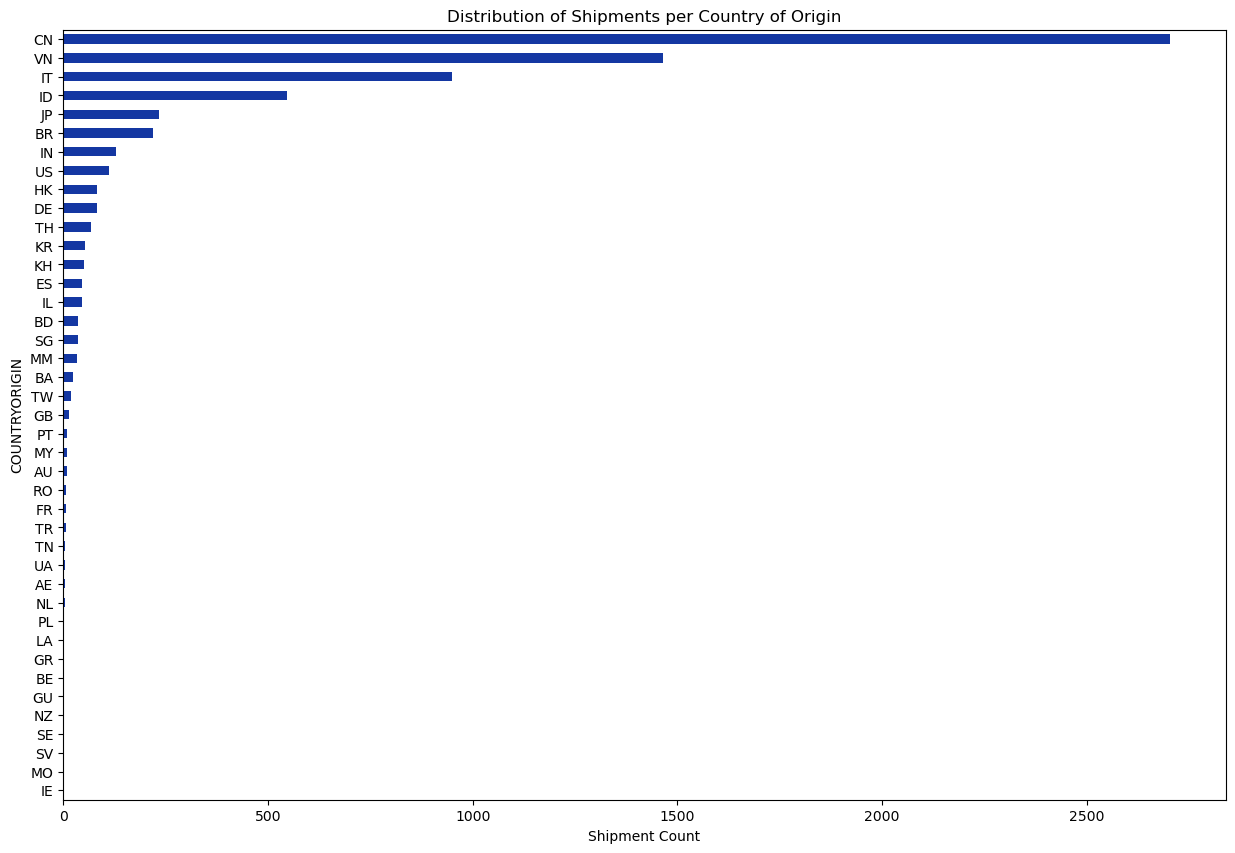

In [5]:
plt.figure(figsize=(15, 10))
(df_shoes
 .value_counts('COUNTRYORIGIN')
 .sort_values(ascending=True)
 .plot
 .barh(color='#1437A2')
 )
plt.title('Distribution of Shipments per Country of Origin')
plt.xlabel('Shipment Count')
plt.show()

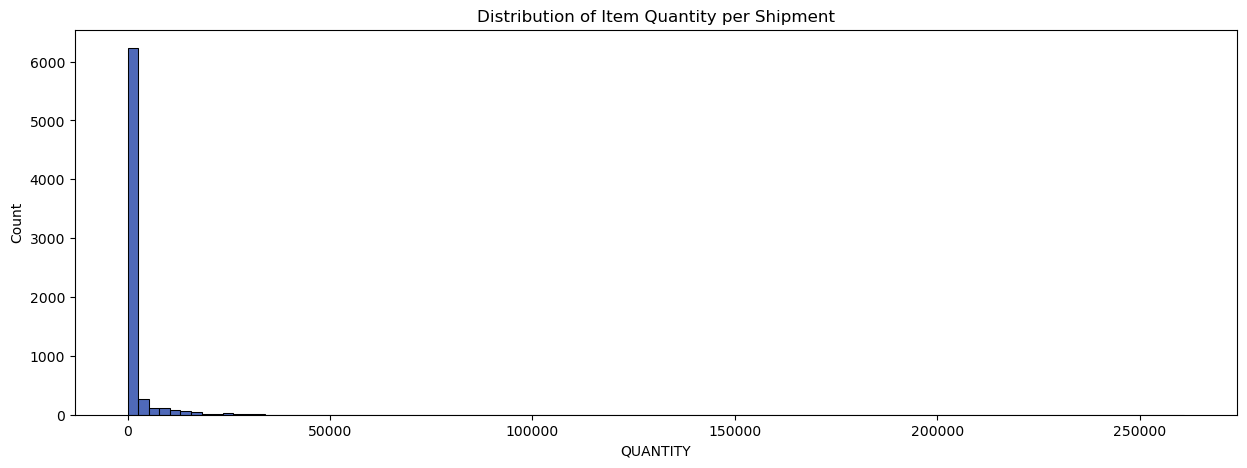

In [6]:
plt.figure(figsize=(15,5))
sns.histplot(df_shoes, x='QUANTITY', bins=100, color='#1437A2')
plt.title('Distribution of Item Quantity per Shipment')
plt.show()

## OUTLIER DETECTION

### ELLIPTIC ENVELOPE

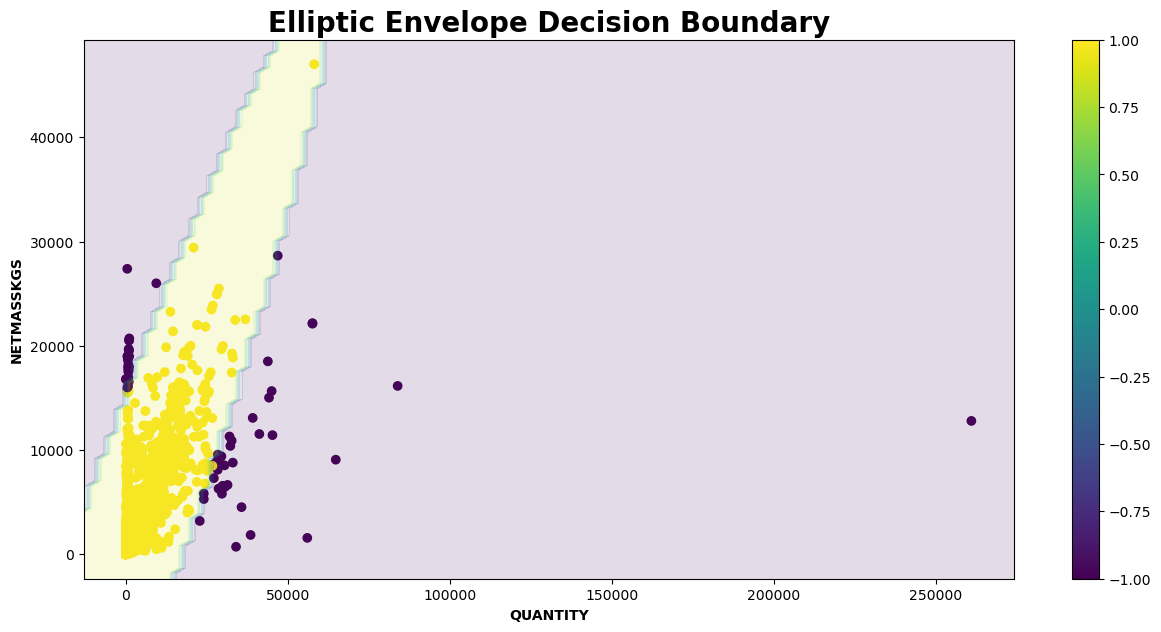

In [7]:
ee = EllipticEnvelope(contamination=0.01)
ee.fit(X)
fig, ax = plt.subplots(figsize=(15, 7))
ee_pred = ee.predict(X)
# Plot data set
plt.scatter(X[:, 0], X[:, 1], c=ee_pred, cmap='viridis')
plt.colorbar()

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]

ax.contourf(
    xx,
    yy,
    ee.predict(np.vstack((xx.flatten(), yy.flatten())).T).reshape(xx.shape),
    alpha=0.15,
)

# Add legend
plt.title('Elliptic Envelope Decision Boundary',
         fontsize=20, fontweight='bold')
plt.xlabel('QUANTITY', fontweight='bold')
plt.ylabel('NETMASSKGS', fontweight='bold')
plt.show()

### ISOLATION FOREST

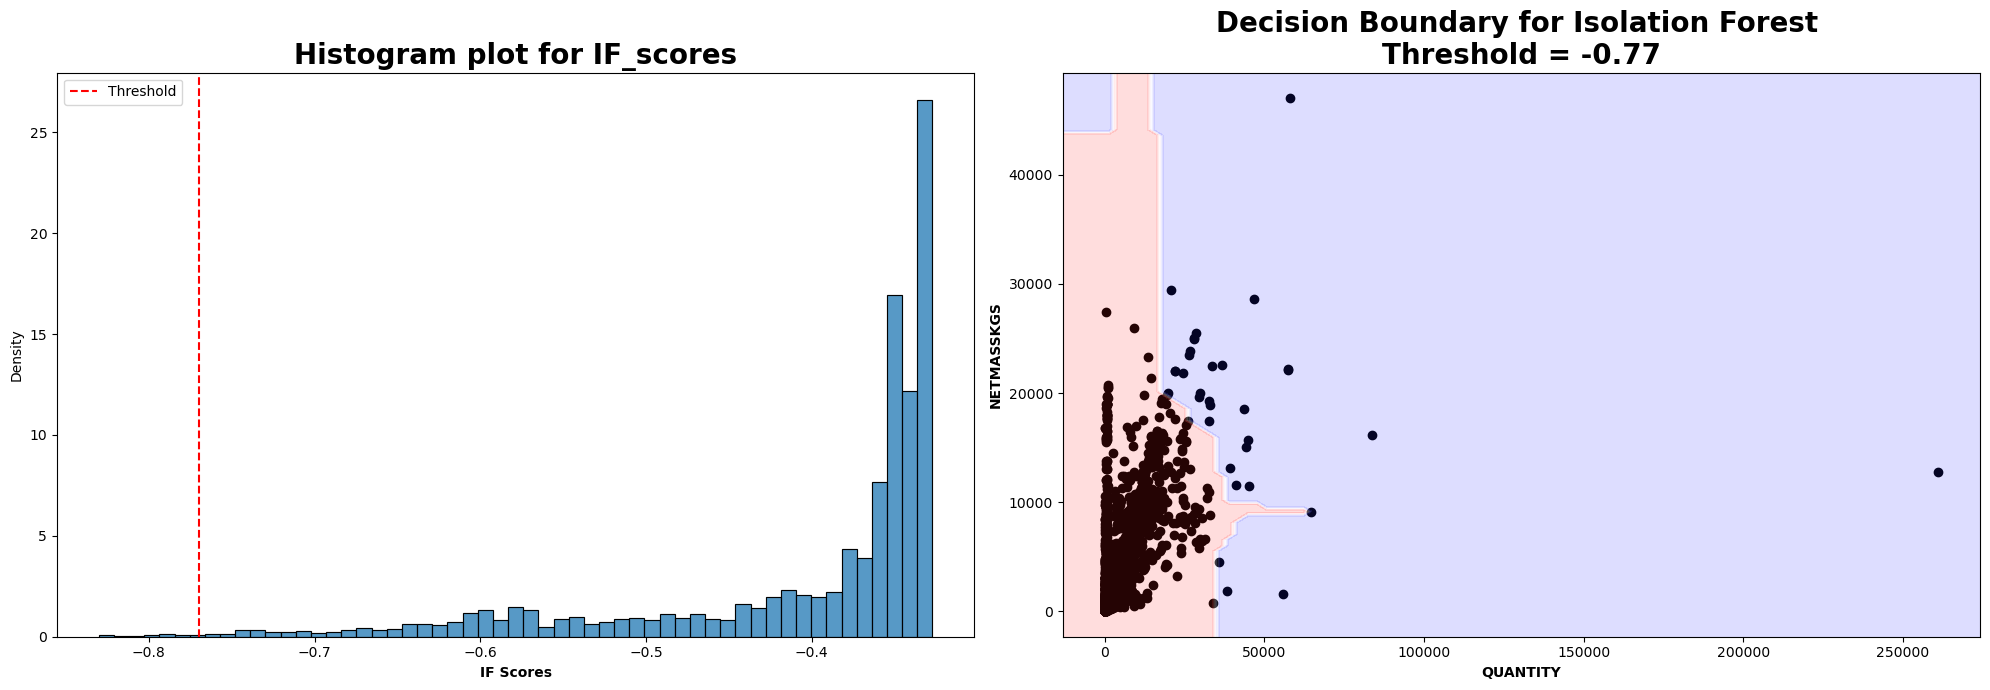

In [8]:
# Fit the Isolation Forest
model_if = IsolationForest(random_state=69)
y_pred = model_if.fit_predict(X)
is_outlier = y_pred == -1
IF_scores = model_if.score_samples(X)

# Set a Threshold for scores and predict
thres_if = -0.77
is_outlier = IF_scores < thres_if

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Plot Distribution of Scores and Threshold
sns.histplot(IF_scores, stat="density", ax=axs[0])
axs[0].axvline(x=thres_if, color="r", linestyle="--", label="Threshold")
axs[0].set_title("Histogram plot for IF_scores",
         fontsize=20, fontweight='bold')
axs[0].set_xlabel('IF Scores', fontweight='bold')
axs[0].legend()

# Plot Decision Boundary for Isolation Forest
inlier_plot = axs[1].scatter(
    X[:, 0], X[:, 1], color="black")

xx, yy = np.meshgrid(
    np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100),
    np.linspace(axs[1].get_ylim()[0], axs[1].get_ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
axs[1].contourf(
    xx,
    yy,
    np.where(
        (model_if.score_samples(
            np.vstack((xx.flatten(), yy.flatten())).T) > thres_if),
        1,
        -1,
    ).reshape(xx.shape),
    alpha=0.15,
    cmap='bwr'
)
axs[1].set_title(
    f'Decision Boundary for Isolation Forest \nThreshold = {thres_if}',
         fontsize=20, fontweight='bold')
axs[1].set_xlabel('QUANTITY', fontweight='bold')
axs[1].set_ylabel('NETMASSKGS', fontweight='bold')

plt.tight_layout()
plt.show()

### ONE CLASS SVM

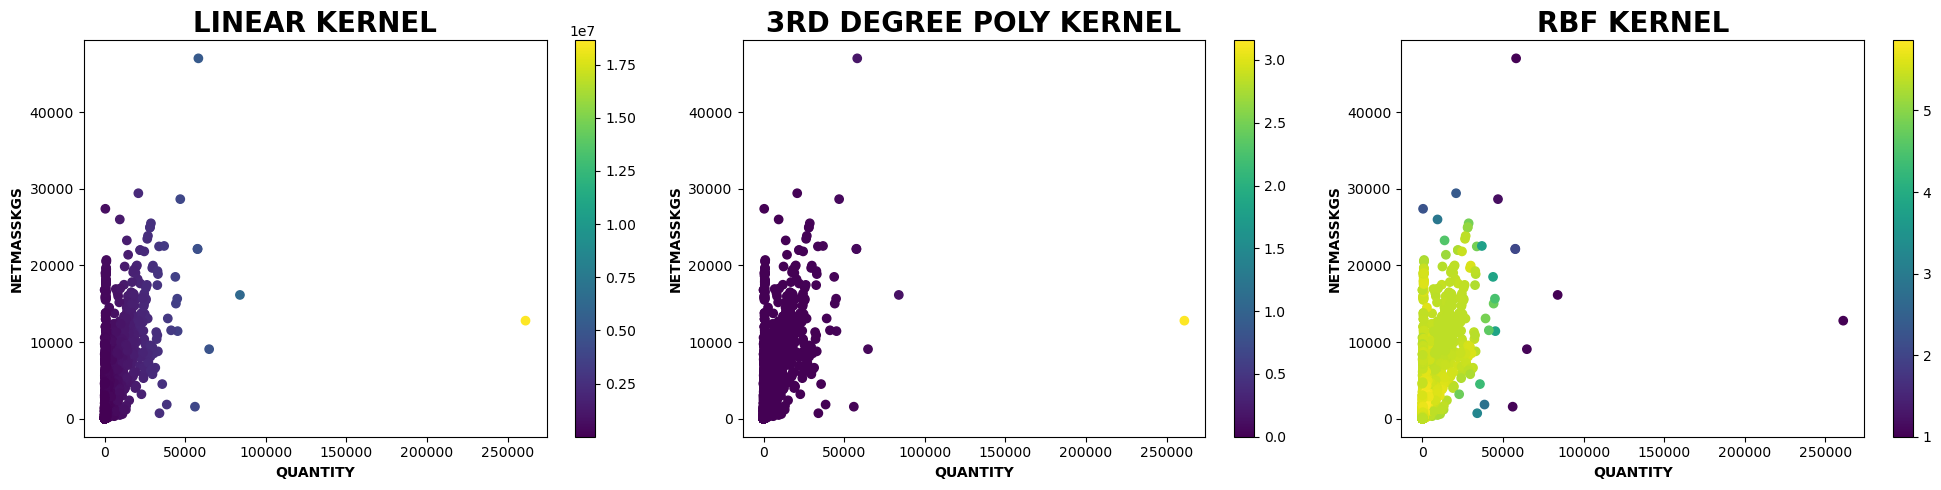

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

model_ocsvm = OneClassSVM(nu=0.01, kernel='linear')
y_pred = model_ocsvm.fit_predict(X)
is_outlier = y_pred == -1
OCSVM_scores = model_ocsvm.score_samples(X)

axs[0].scatter(X[:, 0], X[:, 1], c=OCSVM_scores)
sm1 = ScalarMappable(cmap='viridis')
sm1.set_array(OCSVM_scores)
cbar = plt.colorbar(sm1, ax=axs[0])
axs[0].set_title('LINEAR KERNEL',
         fontsize=20, fontweight='bold')
axs[0].set_xlabel('QUANTITY', fontweight='bold')
axs[0].set_ylabel('NETMASSKGS', fontweight='bold')

model_ocsvm = OneClassSVM(nu=0.01, kernel='poly', degree=3)
y_pred = model_ocsvm.fit_predict(X)
is_outlier = y_pred == -1
OCSVM_scores = model_ocsvm.score_samples(X)

axs[1].scatter(X[:, 0], X[:, 1], c=OCSVM_scores)
sm1 = ScalarMappable(cmap='viridis')
sm1.set_array(OCSVM_scores)
cbar = plt.colorbar(sm1, ax=axs[1])
axs[1].set_title('3RD DEGREE POLY KERNEL',
         fontsize=20, fontweight='bold')
axs[1].set_xlabel('QUANTITY', fontweight='bold')
axs[1].set_ylabel('NETMASSKGS', fontweight='bold')

model_ocsvm = OneClassSVM(nu=0.01, kernel='rbf')
y_pred = model_ocsvm.fit_predict(X)
is_outlier = y_pred == -1
OCSVM_scores = model_ocsvm.score_samples(X)

axs[2].scatter(X[:, 0], X[:, 1], c=OCSVM_scores)
sm1 = ScalarMappable(cmap='viridis')
sm1.set_array(OCSVM_scores)
cbar = plt.colorbar(sm1, ax=axs[2])
axs[2].set_title('RBF KERNEL',
         fontsize=20, fontweight='bold')
axs[2].set_xlabel('QUANTITY', fontweight='bold')
axs[2].set_ylabel('NETMASSKGS', fontweight='bold')
plt.tight_layout()
plt.show()

### GAUSSIAN MIXTURE MODELS

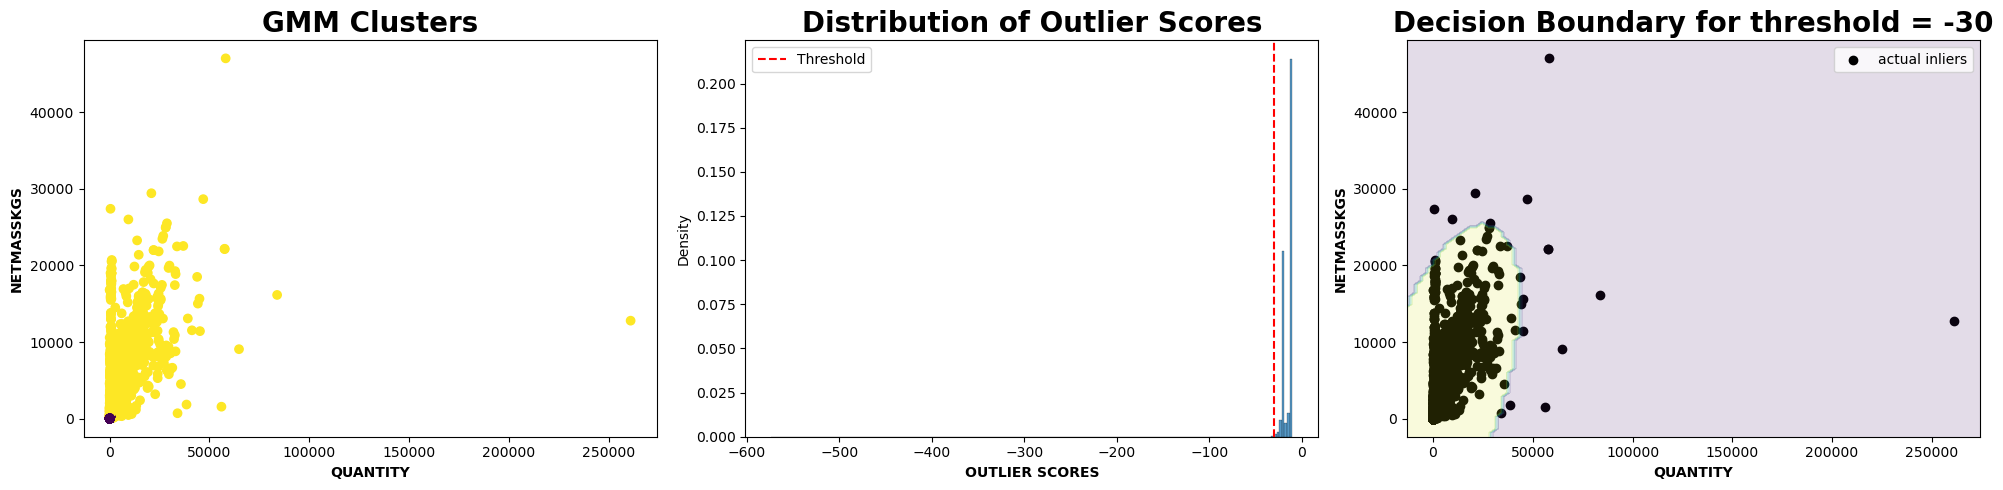

In [10]:
# Fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',
                                random_state=0)
gmm.fit(X)
gmm_scores = gmm.score_samples(X)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
thres_gmm = -30
# PLOT 1
axs[0].scatter(X[:, 0], X[:, 1], c=gmm.predict(X))
axs[0].set_title('GMM Clusters', fontsize=20, fontweight='bold')
axs[0].set_xlabel('QUANTITY', fontweight='bold')
axs[0].set_ylabel('NETMASSKGS', fontweight='bold')
# PLOT 2
sns.histplot(gmm_scores, stat='density', bins=200, ax=axs[1])
axs[1].set_title('Distribution of Outlier Scores',
                 fontsize=20, fontweight='bold')
axs[1].axvline(x=thres_gmm, color="r", linestyle="--", label="Threshold")
axs[1].set_xlabel('OUTLIER SCORES', fontweight='bold')
axs[1].legend()
# PLOT 3
inlier_plot = axs[2].scatter(X[:, 0], X[:, 1], 
                             color="black", label="actual inliers")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
axs[2].contourf(xx, yy, np.where(
    (gmm.score_samples(np.vstack((xx.flatten(), yy.flatten())).T) > thres_gmm),
    1, -1).reshape(xx.shape), alpha=0.15)
axs[2].legend()
axs[2].set_title(f'Decision Boundary for threshold = {thres_gmm}',
                 fontsize=20, fontweight='bold')
axs[2].set_xlabel('QUANTITY', fontweight='bold')
axs[2].set_ylabel('NETMASSKGS', fontweight='bold')
plt.tight_layout()
plt.show()

## RESULTS

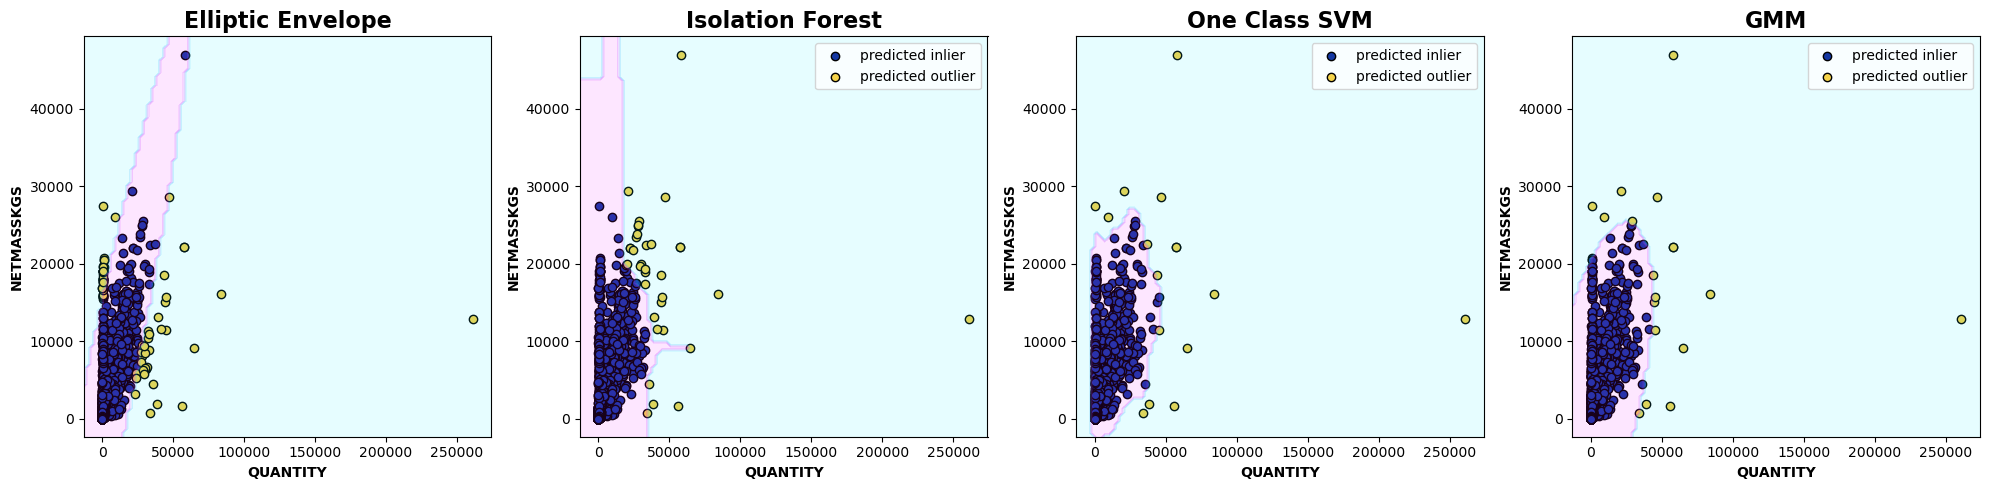

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))


###########################   ELLIPTIC ENVELOPE   ############################
is_outlier_ee = ee_pred < 0
axs[0].scatter(X[~is_outlier_ee, 0], X[~is_outlier_ee, 1],
               c="#1437A2", edgecolors='k', label="predicted inlier")
axs[0].scatter(X[is_outlier_ee, 0], X[is_outlier_ee, 1],
               c="#F5D34A", edgecolors='k', label="predicted outlier")
xx, yy = np.meshgrid(
    np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100),
    np.linspace(axs[0].get_ylim()[0], axs[0].get_ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
Z = ee.predict(zz).reshape(xx.shape)
contour = axs[0].contourf(xx, yy, Z, alpha=0.1, cmap='cool')

axs[0].set_title('Elliptic Envelope', fontsize=16, fontweight='bold')
axs[0].set_xlabel('QUANTITY', fontweight='bold')
axs[0].set_ylabel('NETMASSKGS', fontweight='bold')


##########################    ISOLATION FOREST     ###########################
is_outlier_if = IF_scores < -0.77
axs[1].scatter(X[~is_outlier_if, 0], X[~is_outlier_if, 1],
               c="#1437A2", edgecolors='k', label="predicted inlier")
axs[1].scatter(X[is_outlier_if, 0], X[is_outlier_if, 1], 
               c="#F5D34A", edgecolors='k', label="predicted outlier")
xx, yy = np.meshgrid(
    np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100),
    np.linspace(axs[1].get_ylim()[0], axs[1].get_ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
axs[1].contourf(xx, yy,
                np.where(
                    (model_if.score_samples(
                        np.vstack(
                            (xx.flatten(), yy.flatten())
                        ).T) > thres_if), 1, -1)
                .reshape(xx.shape),
                alpha=0.1,
                cmap='cool'
)
axs[1].legend()
axs[1].set_title('Isolation Forest', fontsize=16, fontweight='bold')
axs[1].set_xlabel('QUANTITY', fontweight='bold')
axs[1].set_ylabel('NETMASSKGS', fontweight='bold')
###############################     OCSVM     ################################
thres_ocsvm = 4
is_outlier_ocsvm = OCSVM_scores < thres_ocsvm
axs[2].scatter(X[~is_outlier_ocsvm, 0], X[~is_outlier_ocsvm, 1],
               c="#1437A2", edgecolors='k', label="predicted inlier")
axs[2].scatter(X[is_outlier_ocsvm, 0], X[is_outlier_ocsvm, 1], 
               c="#F5D34A", edgecolors='k', label="predicted outlier")
xx, yy = np.meshgrid(
    np.linspace(axs[2].get_xlim()[0], axs[2].get_xlim()[1], 100),
    np.linspace(axs[2].get_ylim()[0], axs[2].get_ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
axs[2].contourf(xx, yy,
                np.where(
                    (model_ocsvm.score_samples(
                        np.vstack(
                            (xx.flatten(), yy.flatten())
                        ).T) > thres_ocsvm), 1, -1)
                .reshape(xx.shape),
                alpha=0.1,
                cmap='cool'
)
axs[2].legend()
axs[2].set_title('One Class SVM', fontsize=16, fontweight='bold')
axs[2].set_xlabel('QUANTITY', fontweight='bold')
axs[2].set_ylabel('NETMASSKGS', fontweight='bold')
###############################     GMM      #################################
thres_gmm = -30
is_outlier_gmm = gmm_scores < thres_gmm
axs[3].scatter(X[~is_outlier_gmm, 0], X[~is_outlier_gmm, 1],
               c="#1437A2", edgecolors='k', label="predicted inlier")
axs[3].scatter(X[is_outlier_gmm, 0], X[is_outlier_gmm, 1], 
               c="#F5D34A", edgecolors='k', label="predicted outlier")
xx, yy = np.meshgrid(
    np.linspace(axs[3].get_xlim()[0], axs[3].get_xlim()[1], 100),
    np.linspace(axs[3].get_ylim()[0], axs[3].get_ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
axs[3].contourf(xx, yy,
                np.where(
                    (gmm.score_samples(
                        np.vstack(
                            (xx.flatten(), yy.flatten())
                        ).T) > thres_gmm), 1, -1)
                .reshape(xx.shape),
                alpha=0.1,
                cmap='cool'
)
axs[3].legend()
axs[3].set_title('GMM', fontsize=16, fontweight='bold')
axs[3].set_xlabel('QUANTITY', fontweight='bold')
axs[3].set_ylabel('NETMASSKGS', fontweight='bold')
##############################################################################
plt.tight_layout()
plt.show()

**INSIGHTS:**  
- Elliptic Envelope followed the expected linear relationship of quantity and net mass.
- Isolation Forest was only able to capture outliers on the right side of the plot.
- OCSVM and GMM performed similarly, with OCSVM being more refined.
- Not practical to use GMM in this case since distribution does not seem to be multimodal.


In [12]:
ee_outlier = df_shoes[is_outlier_ee]
if_outlier = df_shoes[is_outlier_if]
ocsvm_outlier = df_shoes[is_outlier_ocsvm]
gmm_outlier = df_shoes[is_outlier_gmm]
print(f'EE Outliers = {len(ee_outlier)}')
print(f'IF Outliers = {len(if_outlier)}')
print(f'OCSVM Outliers = {len(ocsvm_outlier)}')
print(f'GMM Outliers = {len(gmm_outlier)}')

EE Outliers = 71
IF Outliers = 35
OCSVM Outliers = 16
GMM Outliers = 18


In [13]:
df_res_1 = pd.DataFrame({"EE": ee_outlier.value_counts('COUNTRYEXPORT'),
                         "IF": if_outlier.value_counts('COUNTRYEXPORT'),
                         "OCSVM": ocsvm_outlier.value_counts('COUNTRYEXPORT'),
                         "GMM": gmm_outlier.value_counts('COUNTRYEXPORT')})

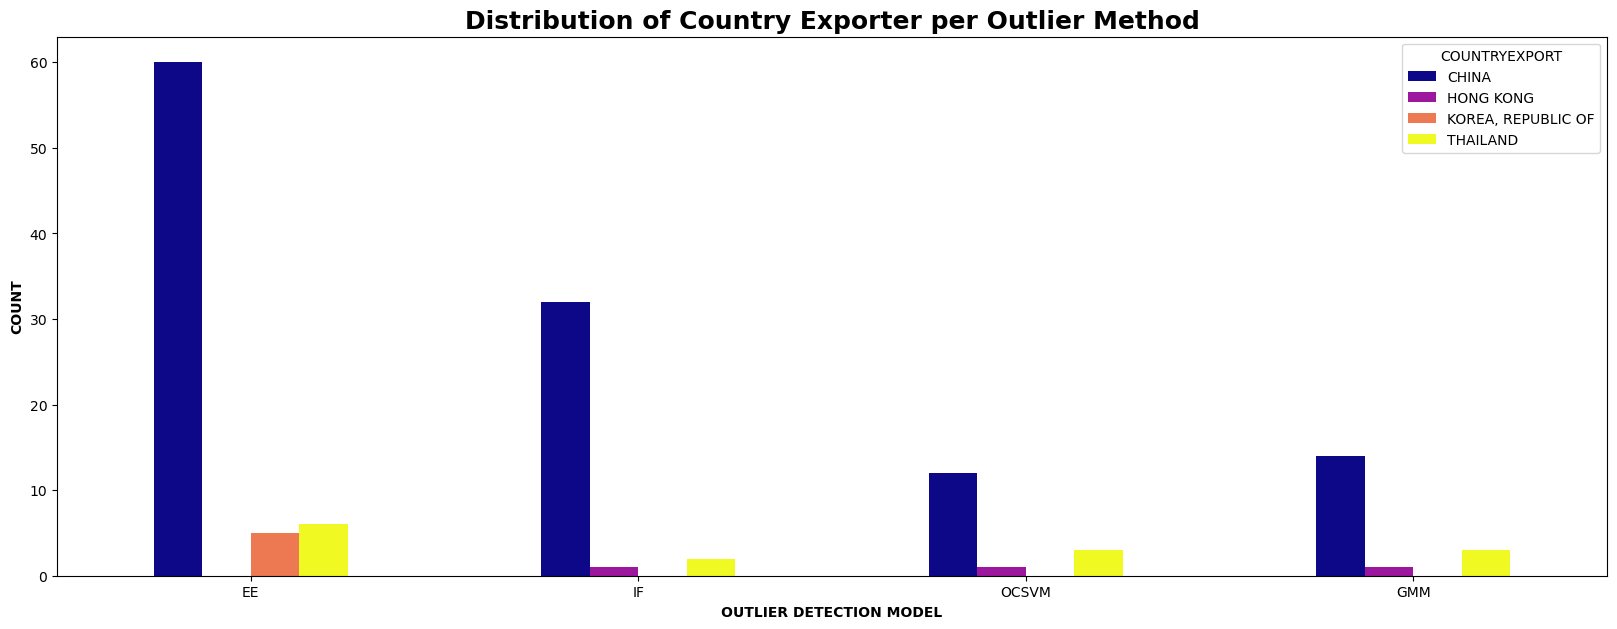

In [14]:
df_res_1.transpose().plot.bar(figsize=(20,7), cmap='plasma')
plt.xticks(rotation=0)
plt.title('Distribution of Country Exporter per Outlier Method',
         fontsize=18, fontweight='bold')
plt.xlabel('OUTLIER DETECTION MODEL',
          fontweight='bold')
plt.ylabel('COUNT',
          fontweight='bold')
plt.show()

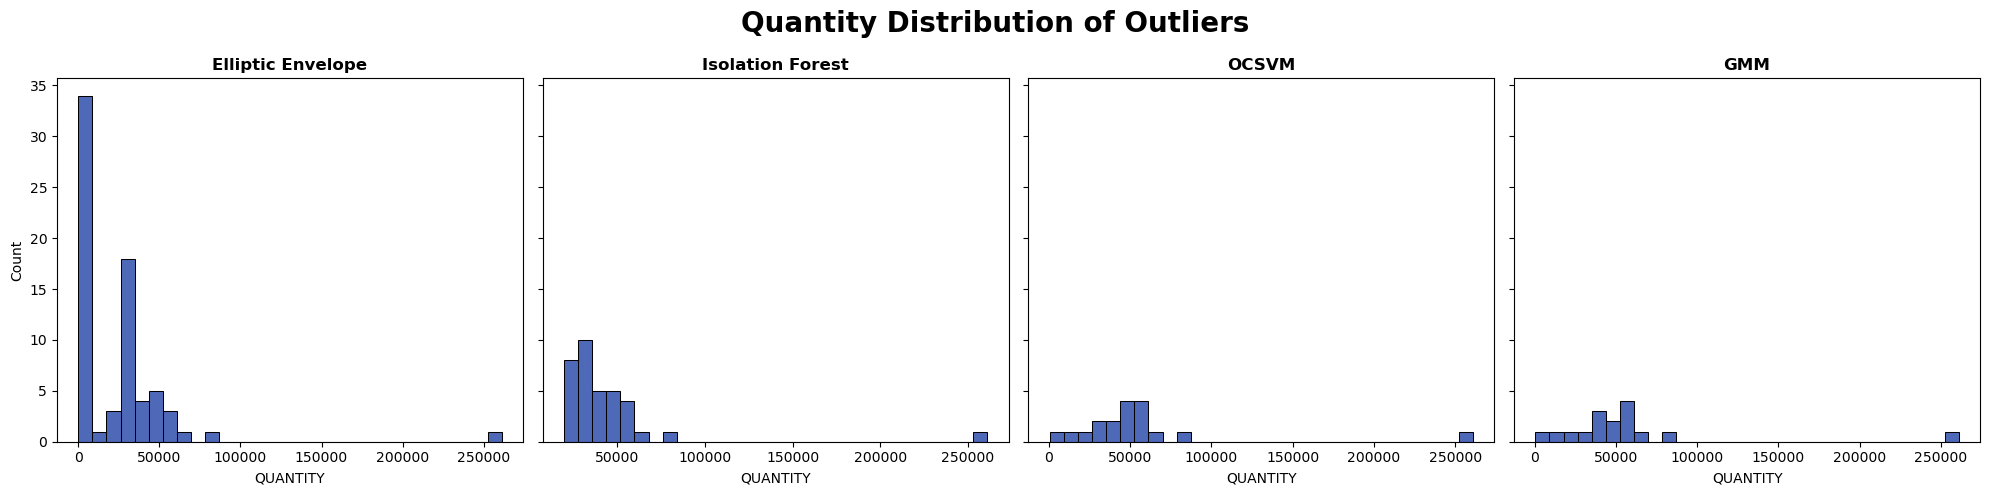

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)
sns.histplot(ee_outlier, x='QUANTITY', bins=30, ax=axs[0], color='#1437A2')
sns.histplot(if_outlier, x='QUANTITY', bins=30, ax=axs[1], color='#1437A2')
sns.histplot(gmm_outlier, x='QUANTITY', bins=30, ax=axs[2], color='#1437A2')
sns.histplot(ocsvm_outlier, x='QUANTITY', bins=30, ax=axs[3], color='#1437A2')
axs[0].set_title('Elliptic Envelope', fontweight='bold')
axs[1].set_title('Isolation Forest', fontweight='bold')
axs[2].set_title('OCSVM', fontweight='bold')
axs[3].set_title('GMM', fontweight='bold')
fig.suptitle('Quantity Distribution of Outliers',
             fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

**INSIGHTS:**
- Elliptic Envelope was able to capture outliers with Quantity 1, while others did not.

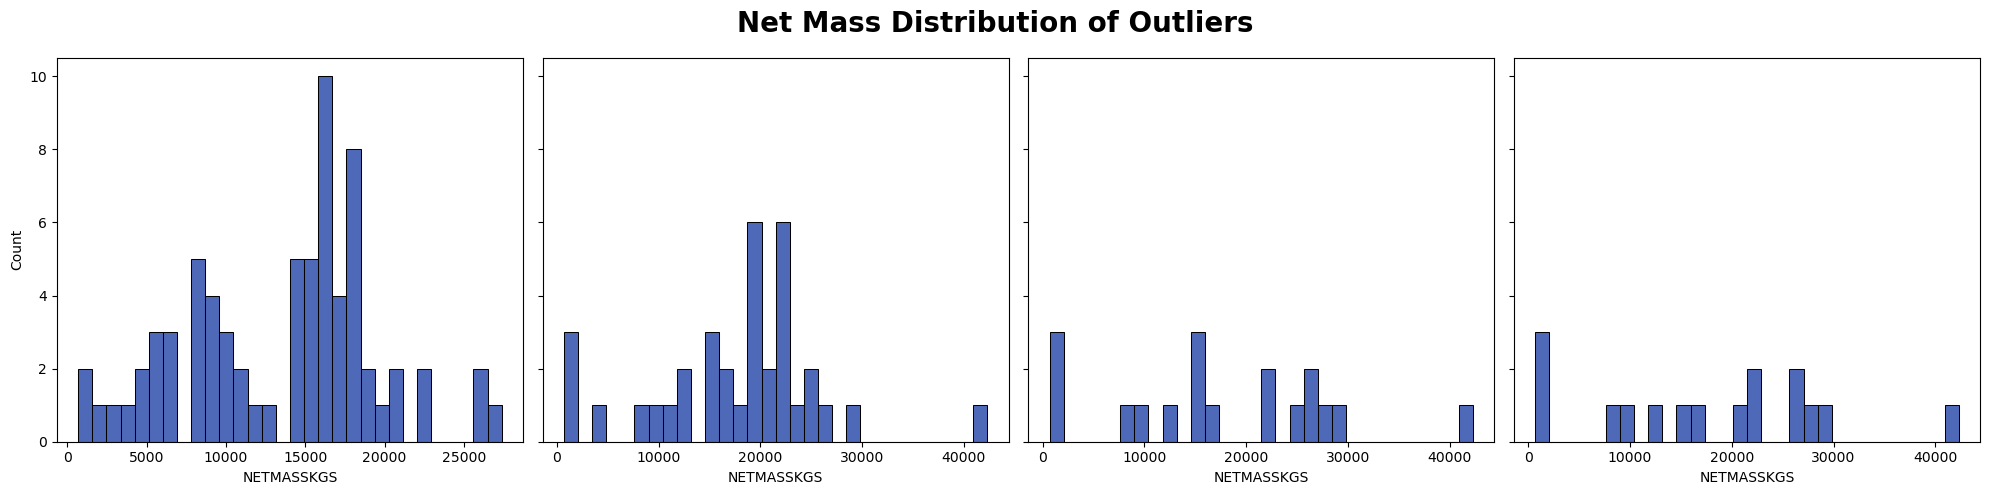

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)
sns.histplot(ee_outlier, x='NETMASSKGS', bins=30, ax=axs[0], color='#1437A2')
sns.histplot(if_outlier, x='NETMASSKGS', bins=30, ax=axs[1], color='#1437A2')
sns.histplot(gmm_outlier, x='NETMASSKGS', bins=30, ax=axs[2], color='#1437A2')
sns.histplot(ocsvm_outlier, x='NETMASSKGS', bins=30, ax=axs[3],
             color='#1437A2')
fig.suptitle('Net Mass Distribution of Outliers',
             fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

**INSIGHTS:**
- The distribution of outliers for elliptic envelope could imply clusters formed.
- Other methods showed more sparsity in the outlier predictions.

### BEST METHOD

The **Elliptic Envelope** seems to be the best method for this case since it was able to align itself to a linear relationship of weight and quantity.
The fact that it was able to capture the outliers with low quantity but high net mass is valuable for this use case.

In [17]:
df_out = ee_outlier[ee_outlier.QUANTITY < 1000].copy()
df_in = df_shoes[~is_outlier_ee].copy()
weight_per_pair_out = df_out.GROSSMASSKGS / df_out.QUANTITY
weight_per_pair = df_in.GROSSMASSKGS / df_in.QUANTITY
weight_per_pair.mean()

6.716197112299892

In [18]:
weight_per_pair_out.mean()

91.83670120880701

Elliptic Envelope's resulting outlier predictions were able to include anomalies for low quantity shipments having significantly high net mass. The mean net mass per pair of the shoe
shipments are at 6.72kgs while the average of the low quantity shipments (below 1000 pairs) are 92 kgs. I have never seen a 92 kg pair of shoe in my life. These shipments could be misdeclared in terms of:
- Quantity: actual shipment might contain more quantity than declared.  
- Content: actual shipment might not contain footwear.  
- Contraband: actual shipment might include contraband hidden within the package.

In [19]:
ee_outlier.loc[ee_outlier.QUANTITY.index[0]]

HSCODE                       64041990000
COUNTRYORIGIN                         CN
COUNTRYEXPORT                      CHINA
GROSSMASSKGS                      1568.0
NETMASSKGS                        1512.0
CUSTOMSVALUE                      3404.8
CURRENCY                             USD
DUTIABLE_FOREIGN                 3566.08
EXCHANGE_RATE                     56.318
DUTIABLEVALUEPHP                200834.5
FREIGHT                            93.18
INSURANCE                           68.1
ARRASTRE                         1721.01
PREF_CODE                          ACFTA
DUTY                            10041.73
VATTAXBASE                     213440.34
VAT                             25612.84
EXCISEADVALOREM                      0.0
DUTIESTAXES                     35654.57
GOODSDESCRIPTION    SLIPPERS (NON WOVEN)
UOM                      Number of pairs
QUANTITY                         56000.0
Name: 25389, dtype: object

The data point above seems to be the opposite, having 56,000 pairs but only with a net mass of 1,512 kgs. This means each pair is only 27 grams. Further inspection or verification
is recommended to make sure the shipment really contains Slippers. We might fall victim again to shipments that contain various trash or e-waste disguised as goods.